# Logistisk regresjon: noen eksempler

In [261]:
import seaborn, sklearn, pandas

Vi lager en liten tabell som viser forhold mellom kvm, pris og plassering (vestkant eller østkant) for ulike boliger i Oslo-området.

In [262]:
df = pandas.DataFrame({"kvm":[84,54,73,74,137,76,31,61,116,42,
                              160,137,152], 
                       "vestkant":[False,False, True, False, True, False, True, False, False, True, 
                                   False,True, False], 
                       "pris":[2890000, 3420000, 6990000, 5300000, 12300000, 
                               5590000, 2000000, 3490000, 8750000, 3330000,
                               9990000, 11600000,7300000]})
df

,kvm,vestkant,pris
0,84,False,2890000
1,54,False,3420000
2,73,True,6990000
3,74,False,5300000
4,137,True,12300000
5,76,False,5590000
6,31,True,2000000
7,61,False,3490000
8,116,False,8750000
9,42,True,3330000


## 1) Lineær regresjon

Vi kan viser tabellen i en _scatter plot_.

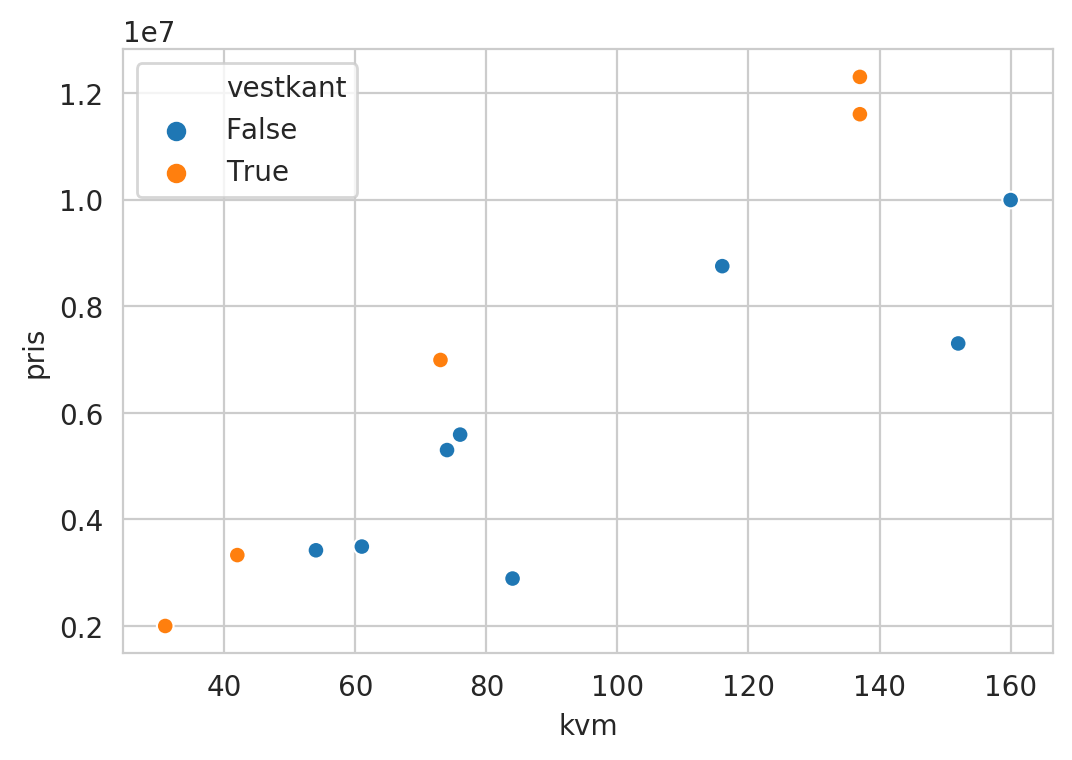

In [263]:
import matplotlib.pyplot as plt
seaborn.set_style("whitegrid")
plt.figure(dpi=200)
fig = seaborn.scatterplot(x="kvm", y="pris", hue="vestkant", data=df)

Vi estimerer ('fit') en lineær regressionsmodell for å predikerer boligprisen avhengig av kvm og plassering:

In [264]:
import sklearn.linear_model
regression = sklearn.linear_model.LinearRegression()
regression.fit(df[["kvm", "vestkant"]], df["pris"])

# Her er vektene og skjæringspunktet:
print("Vektene:", regression.coef_, "Skjæringspunktet:", regression.intercept_)

Vektene: [  72237.15455534 2350862.65353887] Skjæringspunktet: -1174783.636187626


<br>
Med andre ord øker boligprisen med 72 237 kr. per kvadratmeter, og med 2.36 million kr. hvis boligen er på vestkanten.

<br><br>
Etter trening kan modellen brukes til å predikere boligprisen på nye boliger. La oss si vi har en bolig på 97 kvm på østkanten, hva slags pris kan jeg forvente?

In [265]:
to_predict = np.array([[97, False]])
pris = regression.predict(to_predict)[0]
print("Estimert pris: %i kr."%pris)

Estimert pris: 5832220 kr.


<br><br>
Regresjonsmodellen er egentlig en _plan_ i et 3D-rom, siden vi har 2 features og en outputvariabel. Men siden en av features har kun 2 mulige verdier (vestkant eller østkant) kan vi viser resultaten med 2 linjer, en for østkant-boliger og en for vestkant-boliger.

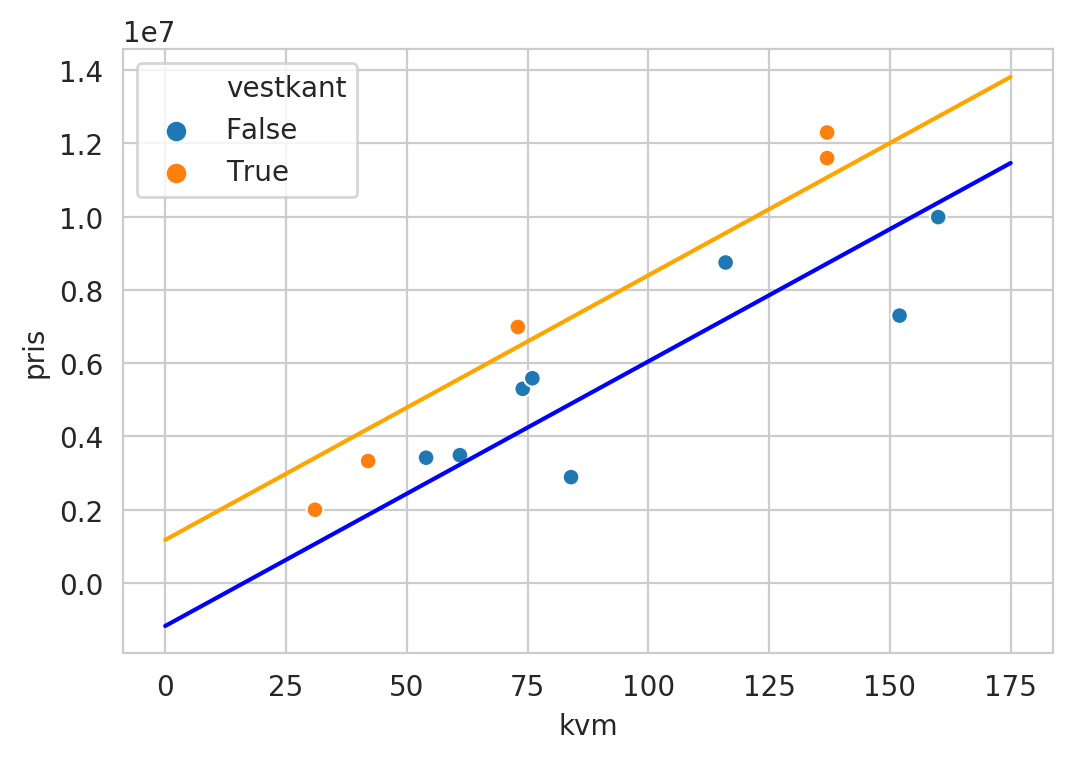

In [266]:
plt.figure(dpi=200)

# Østkant-boliger: vi tegner en line fra (0, b) til (175, w1*175 + b) 
plt.plot([0,175], [regression.intercept_, regression.intercept_+175*regression.coef_[0]], color="blue")

# Vestkant-boliger: vi tegner en line fra (0, w2 + b) til (175, w2 + w1*175 + b) 
plt.plot([0,175], [regression.intercept_+regression.coef_[1], regression.intercept_+regression.coef_[1]+175*regression.coef_[0]], color="orange")

fig = seaborn.scatterplot(x="kvm", y="pris", hue="vestkant", data=df)

<br><br>
## 2) Logistisk regresjon

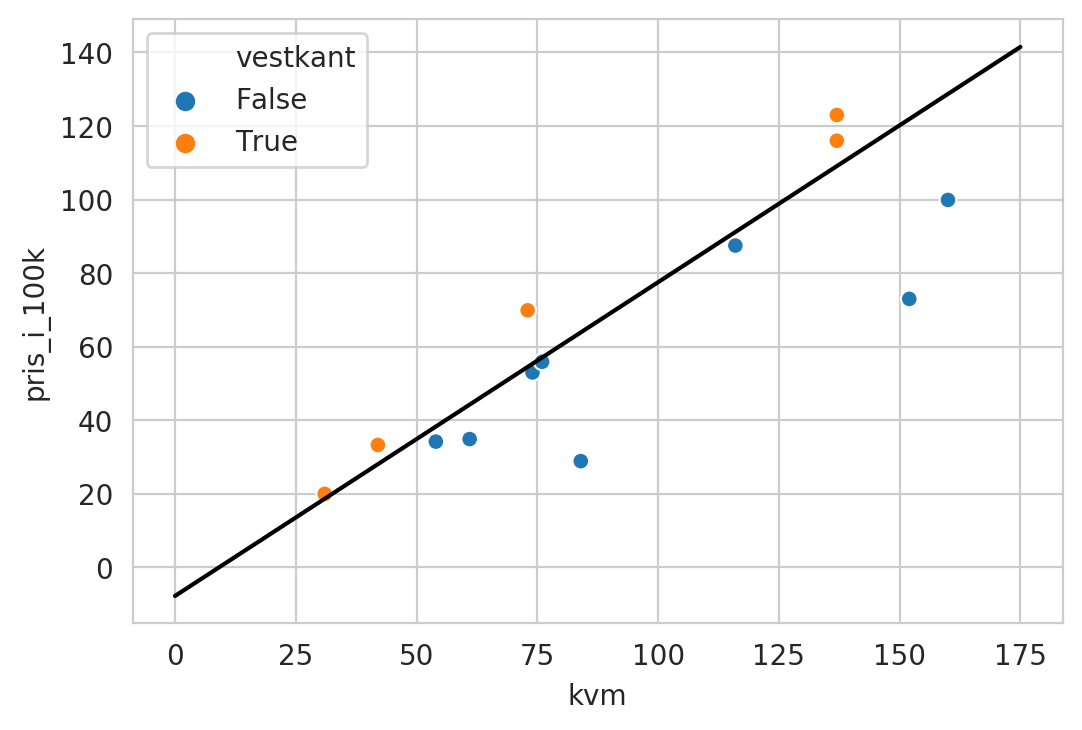

In [267]:
plt.figure(dpi=200)

# Det er vanligvis en dårlig idé å ha features med vidt forskjellige skalaer, slik som kvm (som går fra 0 til ca. 200) og pris 
# (som går fra 0 til ca 20 millioner). Vi skalerer derfor pris ned ved å dele den i 100k kroner:
df["pris_i_100k"] = df.pris / 100000

logit = sklearn.linear_model.LogisticRegression(solver="lbfgs", penalty="none")
logit = logit.fit(df[["kvm", "pris_i_100k"]], df.vestkant)

# Avgjørelsesgrensen ("decision boundary") er punktene hvor wx + b er lik 0
boundary_points = np.array([[0, -logit.intercept_[0] / logit.coef_[0,1]],
                            [175, (-logit.intercept_[0]-175*logit.coef_[0,0]) / logit.coef_[0,1]]])

plt.plot(boundary_points[:,0], boundary_points[:,1], color="black")
fig = seaborn.scatterplot(x="kvm", y="pris_i_100k", hue="vestkant", data=df)

La oss nå ta et eksempel med en bolig som er igjen 97 kvm og er solgt for 6.5 millioner. Den logistiske regresjonsmodellen gir oss en sannsynlighet for at boligen er på vestkant:

In [268]:
probs = logit.predict_proba([[97.0, 65.0]])[0]
print("Sannsynlighet for at boligen ligger på østkanten: %.3f vs. vestkanten: %.3f"%(probs[0], probs[1]))

Sannsynlighet for at boligen ligger på østkanten: 1.000 vs. vestkanten: 0.000


<br><br><br>
Vi kan også se på figuren hvor punktet ligger i forhold til avgjørelsegrensen:

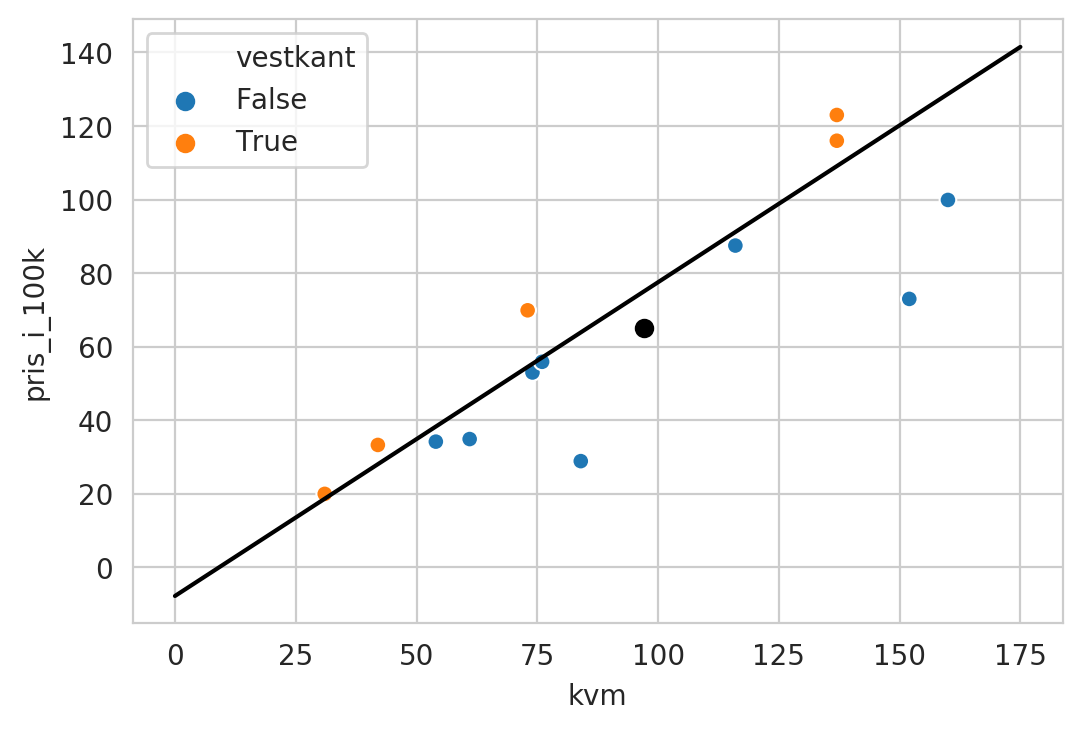

In [269]:
plt.figure(dpi=200)
plt.plot(boundary_points[:,0], boundary_points[:,1], color="black")
plt.scatter([97.0], [65], color="black")
fig = seaborn.scatterplot(x="kvm", y="pris_i_100k", hue="vestkant", data=df)

## 3) Regularisering

Det ser ut som modellen over har overdreven selvtillit. Er det virkelig slik at en bolig på 97 kvm solgt for 6.5 million har _null_ sansynnlighet for å ligger på vestkanten?  Modellen er jo kun estimert på basis av 10 datapunkter, så det kan hende at modellen er overtrent. La oss legge til noe regularisering for å "straffe" modeller som gir veldig høye parametreverdier.  En vanlig regularisering er L2, hvor vi legger $\alpha \sum_j^n \theta_j^2$ til tapsfunksjonen, hvor $\alpha$ indikerer hvor sterk regularisering bør være i forhold til klassifiseringsfeil. 

I `scikit-learn` er det slik at man spesifiserer ikke $\alpha$, men $C$, som tilsvarer $\frac{1}{\alpha * m}$ hvor $m$ er antall datapunkter. En liten $C$ verdi betyr sterk regularisering.

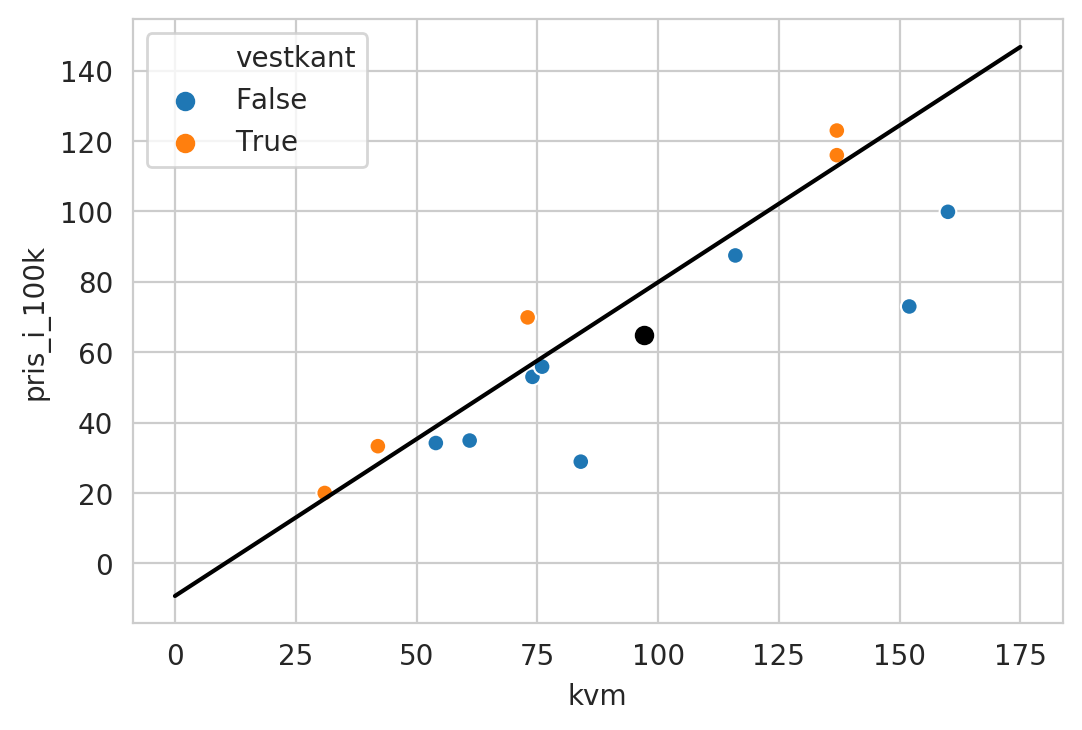

In [270]:
plt.figure(dpi=200)
logit = sklearn.linear_model.LogisticRegression(solver="lbfgs", penalty="l2", C=0.1)
logit = logit.fit(df[["kvm", "pris_i_100k"]], df.vestkant)

# Avgjørelsesgrensen ("decision boundary") er punktene hvor wx + b er lik 0
boundary_points = np.array([[0, -logit.intercept_[0] / logit.coef_[0,1]],
                            [175, (-logit.intercept_[0]-175*logit.coef_[0,0]) / logit.coef_[0,1]]])

plt.plot(boundary_points[:,0], boundary_points[:,1], color="black")
plt.scatter([97.0], [65], color="black")
fig = seaborn.scatterplot(x="kvm", y="pris_i_100k", hue="vestkant", data=df)

Hvis vi nå kjører modellen på nytt ser vi at modellen fortsatt synes boligen ligger på østkanten, men er litt mindre sikker en før:

In [271]:
probs = logit.predict_proba([[97.0, 65.0]])[0]
print("Sannsynlighet for at boligen ligger på østkanten: %.3f vs. vestkanten: %.3f"%(probs[0], probs[1]))

Sannsynlighet for at boligen ligger på østkanten: 0.984 vs. vestkanten: 0.016


<br><br>
## 4) Forklarbarhet

Hvordan kan vi tolke modellens prediksjoner? Logistisk regresjonsmodeller er forholdsvis enkle å tolke ved å se på vektene som assosieres med hver feature:

In [273]:
logit.coef_

array([[-0.29883113,  0.33513879]])

Vektene ovenfor viser at sannsynlighet for at en bolig ligger på vestkanten går ned med størrelse (første feature) og øker med prisen (andre feature). Det vil si at vis vi sammenligner to boliger med samme størrelse, den dyreste vil ha høyere sannsynlighet for å ligge på vestkanten.

(Og hvis vi ser det fra den motsatte vinkelen: hvis vi sammenligner to boliger med samme pris vil den største være minst sannsynlig til å ligge på vestkanten.)

<br><br><br>
## 5) Multi-klasser

La oss se på hvordan logistisk regresjonsmodeller kan brukes til å klassifisere punkter med flere enn 2 klasser:

In [274]:
df["boligtype"] = ["rekkehus", "leilighet", "leilighet", "leilighet", "enebolig", "leilighet", "leilighet", "leilighet", "rekkehus", "leilighet", "rekkehus", "enebolig", "enebolig"]
df

,kvm,vestkant,pris,pris_i_100k,boligtype
0,84,False,2890000,28.9,rekkehus
1,54,False,3420000,34.2,leilighet
2,73,True,6990000,69.9,leilighet
3,74,False,5300000,53.0,leilighet
4,137,True,12300000,123.0,enebolig
5,76,False,5590000,55.9,leilighet
6,31,True,2000000,20.0,leilighet
7,61,False,3490000,34.9,leilighet
8,116,False,8750000,87.5,rekkehus
9,42,True,3330000,33.3,leilighet


/nr/samba/user/plison/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


(0, 180)

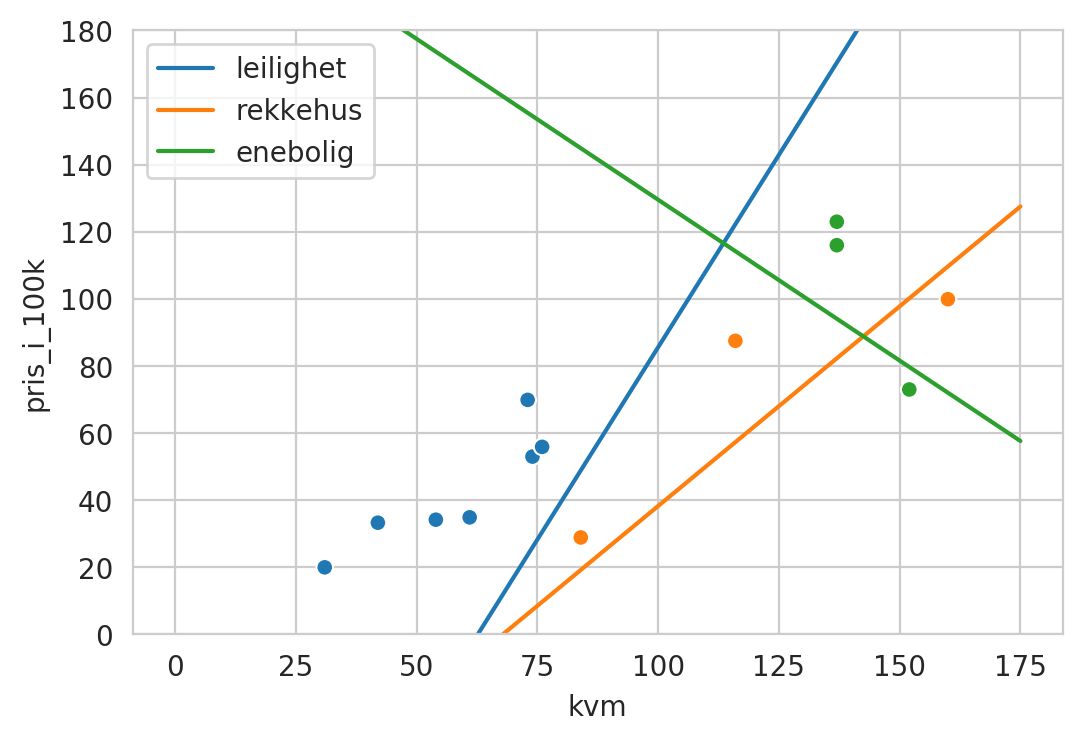

In [275]:
plt.figure(dpi=200)
logit = sklearn.linear_model.LogisticRegression(solver="lbfgs", penalty="l2", C=0.1)
logit = logit.fit(df[["kvm", "pris_i_100k"]], df.boligtype.map({"leilighet":0, "rekkehus":1, "enebolig":2}))

boundary_points_leilighet = np.array([[0, -logit.intercept_[0] / logit.coef_[0,1]],
                            [175, (-logit.intercept_[0]-175*logit.coef_[0,0]) / logit.coef_[0,1]]])
boundary_points_rekkehus = np.array([[0, -logit.intercept_[1] / logit.coef_[1,1]],
                            [175, (-logit.intercept_[1]-175*logit.coef_[1,0]) / logit.coef_[1,1]]])
boundary_points_enebolig = np.array([[0, -logit.intercept_[2] / logit.coef_[2,1]],
                            [175, (-logit.intercept_[2]-175*logit.coef_[2,0]) / logit.coef_[2,1]]])

plt.plot(boundary_points_leilighet[:,0], boundary_points_leilighet[:,1], label="leilighet")
plt.plot(boundary_points_rekkehus[:,0], boundary_points_rekkehus[:,1], label="rekkehus")
plt.plot(boundary_points_enebolig[:,0], boundary_points_enebolig[:,1], label="enebolig")
plt.legend()
fig = seaborn.scatterplot(x="kvm", y="pris_i_100k", hue="boligtype", hue_order=["leilighet", "rekkehus", "enebolig"], data=df, legend=False)
plt.ylim(0,180)


Hva er det mest sannsynlige boligtyp for en bolig som er 97 kvm og koster 6.2 millioner?

In [278]:
predictions = logit.predict_proba([[97,62.0]])[0]
print("Sansynnligheter: leilighet=%.3f, rekkehus=%.3f, enebolig:%.3f"%(predictions[0], predictions[1], predictions[2]))

Sansynnligheter: leilighet=0.325, rekkehus=0.564, enebolig:0.111


<br><br>
Til slutt kan vi se hvordan disse grensene fordeler planen i ulike "regioner" assosiert med hver klasse:

No handles with labels found to put in legend.


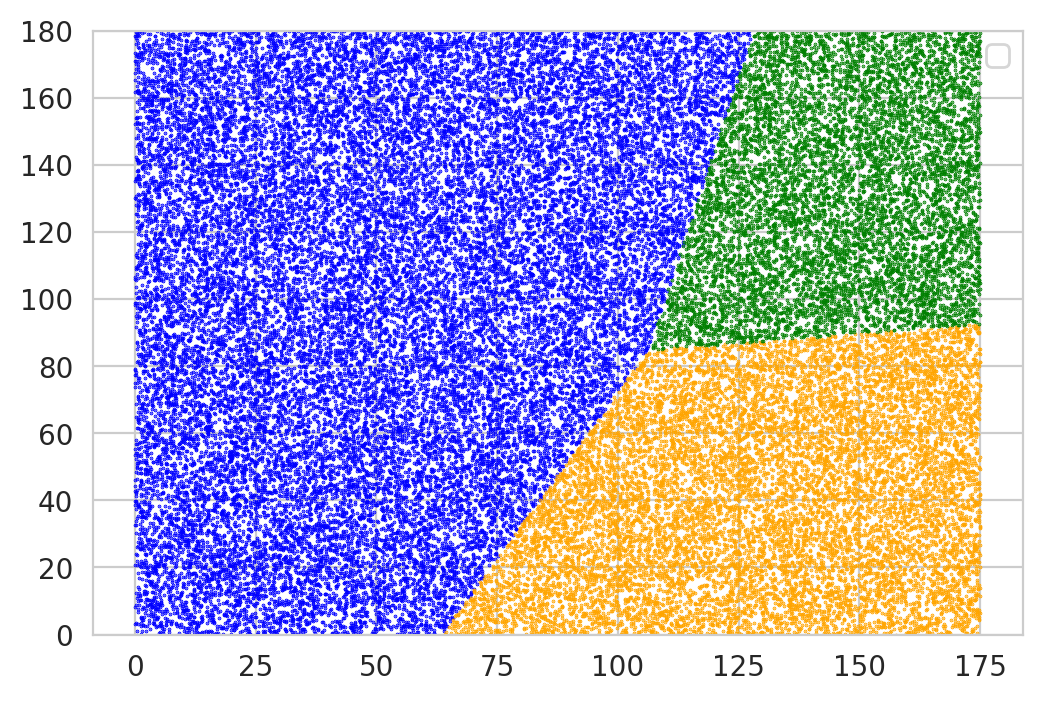

In [277]:
plt.figure(dpi=200)

# Vi genererer 50 000 tilfeldige punkter mellom 0 og 175 kvm og mellom 0 og 18 millioner kr.
random_points = np.vstack((np.random.random(50000)*175, np.random.random(50000)*180)).T

# Vi beregner de meste sannsynlige klassene for hver punkt
classes = logit.predict(random_points)

# Og vise klassene på plane
plt.scatter(random_points[:,0][classes==0], random_points[:,1][classes==0], color="blue", s=0.1)
plt.scatter(random_points[:,0][classes==1], random_points[:,1][classes==1], color="orange", s=.1)
plt.scatter(random_points[:,0][classes==2], random_points[:,1][classes==2], color="green", s=0.1)
plt.ylim(0,180)
plt.legend()